# Importação de Bibliotecas

In [12]:
# Módulos de manipulação de dados
import numpy as np
import pandas as pd
import scipy
from math import sqrt

# Módulos gráficos
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import matplotlib.cm as cm
import seaborn as sns

# Modelos de Modelagem
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasRegressor

# Otimização Bayesiana
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import sys

# Base de dados

In [248]:
df = pd.read_excel(r'C:\Users\alexandre.alves_ze\Documents\00. Monografia\RNA_MLP_YieldCurve\df_RNA2.xlsx')

# Transformando coluna de datas em index
df = df.set_index('date')

# Drop em NaN
df = df.dropna()

# Visualização
df.head()

,M1,M2,M3,M6,M9,M12,M24,M36,M48,M60,...,M3_12mo,M12_1mo,M12_6mo,M12_12mo,M36_1mo,M36_6mo,M36_12mo,M60_1mo,M60_6mo,M60_12mo
date,,,,,,,,,,,,,,,,,,,,,
09-01-2006,17.740182,17.566360,17.399818,17.059122,16.705152,16.488824,15.961299,15.491930,15.255337,15.036384,...,12.789329,15.845268,14.380370,12.439519,15.000623,14.944121,12.250018,14.536886,15.108497,12.281705
10-01-2006,17.645399,17.503714,17.343773,16.946689,16.599468,16.381932,15.858515,15.423501,15.224757,14.974188,...,12.790458,15.875394,14.400880,12.415592,14.972101,14.982343,12.169219,14.482117,15.148891,12.190801
11-01-2006,17.559551,17.497823,17.325622,16.950004,16.602846,16.379841,15.819653,15.403037,15.168945,14.944059,...,12.768769,15.881060,14.362687,12.378058,14.904578,14.943681,12.139917,14.301528,15.089890,12.192520
12-01-2006,17.499928,17.456166,17.287956,16.910126,16.565996,16.346437,15.800996,15.361025,15.111922,14.873235,...,12.755620,15.826799,14.373018,12.342511,14.789105,14.851598,12.140257,14.082579,14.890431,12.204590
13-01-2006,17.439030,17.431589,17.260307,16.894521,16.518858,16.299075,15.714698,15.287913,15.037662,14.803268,...,12.745142,15.789845,14.371259,12.324382,14.751286,14.791345,12.139599,14.078056,14.840568,12.181678


In [9]:
df.shape

(3438, 63)

## Separação da base em treino e teste

A fim de igualar o período de teste para o DNS e o MLP, a divisão será realizada tendo como base o intervalo observado para o DNS.

- Tamanho da base: 3702
- 70% da base: 2592
- 30% da base: 1110

__teste__: 0 ~ 2592 <br>
__treino__: 2593 ~ 3701

In [251]:
df_train = df[0:2592]
df_test = df[2593:]

# Preparação dos dados

## Predição de M3

In [15]:
# Variáveis explicativas
x_train = df_train[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_train = x_train.to_numpy()

x_test = df_test[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_test = x_test.to_numpy()



# Variável dependente
y_train = df_train['M3_1mo']
y_train = y_train.to_numpy()
y_train = y_train.reshape(-1, 1)

y_test = df_test['M3_1mo']
y_test = y_test.to_numpy()
y_test = y_test.reshape(-1, 1)

### Pré-processamento

In [17]:
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler()
x_scaler.fit(x_train)
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

### Desenvolvimento e Treinamento da RNA MLP Baseline

In [18]:
# Definição da estrutura do modelo
modelo_baseline = keras.Sequential()

# Camada de Entrada
modelo_baseline.add(layers.Dropout(0.1,
                                   input_shape = (x_train_scaled.shape[1],)))

# Camada(s) Oculta(s)
modelo_baseline.add(layers.Dense(8, 
                                 activation = 'relu',
                                 kernel_initializer = keras.initializers.GlorotUniform(),
                                 kernel_regularizer = keras.regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4)))
modelo_baseline.add(layers.Dropout(0.2))

# Camada de Saída
modelo_baseline.add(layers.Dense(1, activation = 'relu'))

# Configurações de Otimização
modelo_baseline.compile(loss = 'mean_squared_error', 
                        optimizer = keras.optimizers.Adam(),
                        metrics = keras.metrics.RootMeanSquaredError())

# Definição do Early Stopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_root_mean_squared_error', 
                                         patience = 5)

# Treinamento com o conjunto de Treino
n_epochs = 5
n_batchs = 100
hist_baseline = modelo_baseline.fit(x = x_train_scaled, 
                                    y = y_train_scaled, 
                                    epochs = n_epochs,
                                    batch_size = n_batchs,
                                    validation_split = 0.2,
                                    callbacks = callback,
                                    verbose = 1)

Epoch 1/5
21/21 [==============================] - 0s 7ms/step - loss: 0.1894 - root_mean_squared_error: 0.4327 - val_loss: 0.4165 - val_root_mean_squared_error: 0.6437
Epoch 2/5
21/21 [==============================] - 0s 2ms/step - loss: 0.1113 - root_mean_squared_error: 0.3304 - val_loss: 0.0208 - val_root_mean_squared_error: 0.1369
Epoch 3/5
21/21 [==============================] - 0s 2ms/step - loss: 0.0706 - root_mean_squared_error: 0.2617 - val_loss: 0.0330 - val_root_mean_squared_error: 0.1759
Epoch 4/5
21/21 [==============================] - 0s 2ms/step - loss: 0.0539 - root_mean_squared_error: 0.2277 - val_loss: 0.0280 - val_root_mean_squared_error: 0.1612
Epoch 5/5
21/21 [==============================] - 0s 2ms/step - loss: 0.0395 - root_mean_squared_error: 0.1937 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1321


### Análise de desempenho

In [19]:
score_train, rmse_train = modelo_baseline.evaluate(x_train_scaled, y_train_scaled, verbose=0)
score_test, rmse_test = modelo_baseline.evaluate(x_test_scaled, y_test_scaled, verbose=0)

print('RMSE no conjunto de Treino: {:.2}'.format(rmse_train))
print('RMSE no conjunto de Teste: {:.2}'.format(rmse_test))

RMSE no conjunto de Treino: 0.095
RMSE no conjunto de Teste: 0.12


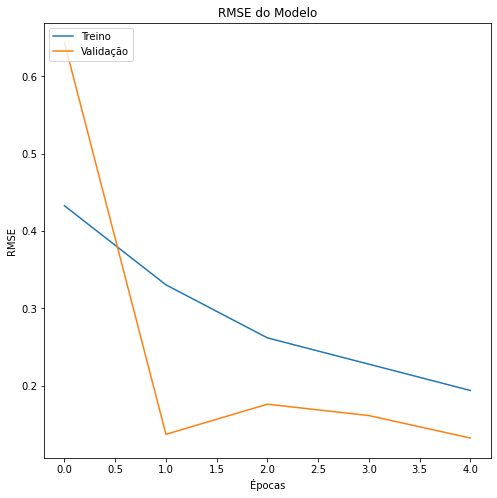

In [20]:
# Gráfico com a evolução do treinamento
fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(hist_baseline.history['root_mean_squared_error'])
plt.plot(hist_baseline.history['val_root_mean_squared_error'])
plt.title('RMSE do Modelo')
plt.ylabel('RMSE')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

In [22]:
y_train_pred = y_scaler.inverse_transform(modelo_baseline.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_baseline.predict(x_test_scaled))

# Avaliação do melhor modelo
print('RMSE Treino: ', sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
print('RMSE Teste: ', sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

RMSE Treino:  0.9293799386204543
RMSE Teste:  1.1558503125468065


### Definição do espaço hiperparamétrico

In [206]:
# Número de camadas de 1 a 10
ehp_layers = np.arange(1, 10, 1)

# Número de neurônios de 2, 4, 8, 16, 32, 64 e 128
ehp_neurons = np.power(2, np.arange(1, 8, 1)) 

# Função de ativação
ehp_fnactiv = ['relu','tanh']

# Dropout
ehp_dropout = np.arange(0, 0.5, 0.1)

# Definição do dicionário de parâmetros
param_grid = dict(num_layers = ehp_layers,
                  num_neurons = ehp_neurons,
                  fn_activ = ehp_fnactiv,
                  dropout = ehp_dropout,
                 )

In [207]:
param_grid

{'num_layers': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'num_neurons': array([  2,   4,   8,  16,  32,  64, 128], dtype=int32),
 'fn_activ': ['relu', 'tanh'],
 'dropout': array([0. , 0.1, 0.2, 0.3, 0.4])}

In [243]:
# Construção do modelo Tensorflow encapsulado como Scikit-Learn
def modelo_DL(num_layers = 1, num_neurons = 8, fn_activ = 'relu', dropout = 0.0):    
    
    # Definição da estrutura do modelo
    model = keras.Sequential()
    
    # Camada de Entrada
    model.add(layers.Dropout(0.1,
                             input_shape = (x_train_scaled.shape[1],)))

    # Camada(s) Oculta(s)
    model.add(layers.Dense(num_neurons, 
                           activation = str(fn_activ),
                           kernel_initializer = keras.initializers.GlorotUniform(),
                           kernel_regularizer = keras.regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4)))
    model.add(layers.Dropout(dropout))
    
    # Adiciona demais camadas ocultas
    if num_layers > 1:
        for i in np.arange(2, num_layers, 1):
            model.add(layers.Dense(num_neurons, 
                                   activation = str(fn_activ),
                                   kernel_initializer = keras.initializers.GlorotUniform(),
                                   kernel_regularizer = keras.regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4)))
            model.add(layers.Dropout(dropout))
    
    # Camada de Saída
    model.add(layers.Dense(1))
    
    # Configurações de Otimização
    model.compile(loss = 'mean_squared_error', 
                  optimizer = keras.optimizers.Adam(),
                  metrics = keras.metrics.RootMeanSquaredError())
   
    return model

# Definição do Early Stopping
callback = keras.callbacks.EarlyStopping(monitor = 'val_root_mean_squared_error', 
                                         patience = 100)

n_epochs = 200
n_batchs = 100

modelo_tf = KerasRegressor(modelo_DL,
                           num_layers = 1, num_neurons = 8, fn_activ = 'relu',
                           epochs = n_epochs,
                           batch_size = n_batchs,
                           validation_split = 0.2,
                           callbacks = callback,
                           verbose = 0)

### Bayesian Optimization

In [244]:
bo_space = {'num_layers': hp.choice('num_layers', param_grid['num_layers']),
            'num_neurons': hp.choice('num_neurons', param_grid['num_neurons']),
            'fn_activ': hp.choice('fn_activ', param_grid['fn_activ']),
            'dropout' : hp.choice('dropout', param_grid['dropout'])
           }

In [245]:
bo_space

{'num_layers': <hyperopt.pyll.base.Apply at 0x1f49bf52460>,
 'num_neurons': <hyperopt.pyll.base.Apply at 0x1f49005f2b0>,
 'fn_activ': <hyperopt.pyll.base.Apply at 0x1f490025f70>,
 'dropout': <hyperopt.pyll.base.Apply at 0x1f490025490>}

In [246]:
def bo_rna(param):   

    print ('Hiperparametros testados: ', param)
    modelo_bo = modelo_DL(num_layers = param['num_layers'], 
                          num_neurons = param['num_neurons'],
                          fn_activ = param['fn_activ'],
                          dropout = param['dropout']
                         )
    
    modelo_bo.fit(x_train_scaled, 
                  y_train_scaled,
                  epochs = n_epochs,
                  batch_size = n_batchs,
                  validation_split = 0.2,
                  callbacks = callback,
                  verbose = 0)
    
    # Calcula RMSE no conjunto de Teste
    y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))
    rmse_test = sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    print('RMSE Teste: ', rmse_test)
    
    # sys.stdout.flush() 
    return {'loss': rmse_test, 'status': STATUS_OK}

In [212]:
trials = Trials()
bo_search = fmin(fn = bo_rna, 
                 space = bo_space,
                 algo = tpe.suggest,
                 max_evals = 50,
                 trials = trials)

Hiperparametros testados:                             
{'dropout': 0.30000000000000004, 'fn_activ': 'relu', 'num_layers': 7, 'num_neurons': 8}
RMSE Teste:                                           
3.0685929713075146                                    
Hiperparametros testados:                                                       
{'dropout': 0.2, 'fn_activ': 'relu', 'num_layers': 3, 'num_neurons': 16}        
RMSE Teste:                                                                     
1.8590158471519913                                                              
Hiperparametros testados:                                                       
{'dropout': 0.4, 'fn_activ': 'tanh', 'num_layers': 6, 'num_neurons': 16}        
RMSE Teste:                                                                     
1.082263203737758                                                               
Hiperparametros testados:                                                       
{'dropout': 0.3000

In [213]:
from hyperopt import space_eval

bo_melhor_hp = space_eval(bo_space, bo_search)
print('Melhor conjunto de hiperparâmetros: ', bo_melhor_hp)

Melhor conjunto de hiperparâmetros:  {'dropout': 0.0, 'fn_activ': 'tanh', 'num_layers': 5, 'num_neurons': 8}


In [214]:
modelo_bo = modelo_DL(num_layers = bo_melhor_hp['num_layers'],
                      num_neurons = bo_melhor_hp['num_neurons'],
                      fn_activ = bo_melhor_hp['fn_activ'],
                      dropout = bo_melhor_hp['dropout'])

hist_bo = modelo_bo.fit(x_train_scaled, 
                        y_train_scaled,
                        epochs = n_epochs,
                        batch_size = n_batchs,
                        validation_split = 0.2,
                        callbacks = callback,
                        verbose = 0)

In [215]:
score_train, rmse_train = modelo_bo.evaluate(x_train_scaled, y_train_scaled, verbose=0)
score_test, rmse_test = modelo_bo.evaluate(x_test_scaled, y_test_scaled, verbose=0)

print('RMSE no conjunto de Treino: {:.2}'.format(rmse_train))
print('RMSE no conjunto de Teste: {:.2}'.format(rmse_test))

RMSE no conjunto de Treino: 0.026
RMSE no conjunto de Teste: 0.029


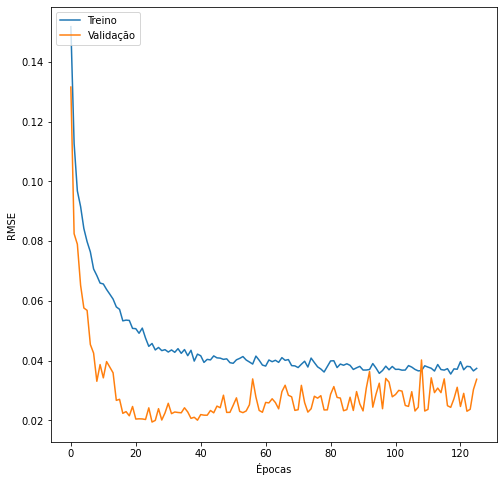

In [220]:
# Gráfico com a evolução do treinamento
fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(hist_bo.history['root_mean_squared_error'])
plt.plot(hist_bo.history['val_root_mean_squared_error'])
#plt.title('RMSE do Modelo')
plt.ylabel('RMSE')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()
fig.savefig('MLP_3M_1mo.pdf', bbox_inches='tight')

In [217]:
y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

# Avaliação do melhor modelo
print('RMSE Treino: ', sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
print('RMSE Teste: ', sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

RMSE Treino:  0.26044910206144317
RMSE Teste:  0.28505610238402


In [233]:
y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('Média y original: %.4f'% y_test_pred.mean())
print('Desvio padrão y original: %.4f'% y_test_pred.std())

print('Média y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).mean())
print('Desvio padrão y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).std())

Média y original: 8.0832
Desvio padrão y original: 2.6221
Média y padronizado: 0.1144
Desvio padrão y padronizado: 0.2667


## M3 6mo ahead

Hiperparametros testados:                             
{'dropout': 0.0, 'fn_activ': 'tanh', 'num_layers': 8, 'num_neurons': 32}
RMSE Teste:                                           
2.9827344148766377                                    
Hiperparametros testados:                                                       
{'dropout': 0.0, 'fn_activ': 'tanh', 'num_layers': 5, 'num_neurons': 2}         
RMSE Teste:                                                                     
1.5394059976792778                                                              
Hiperparametros testados:                                                       
{'dropout': 0.0, 'fn_activ': 'tanh', 'num_layers': 8, 'num_neurons': 8}         
RMSE Teste:                                                                     
1.9586964395702808                                                              
Hiperparametros testados:                                                       
{'dropout': 0.1, 'fn_activ': 'rel

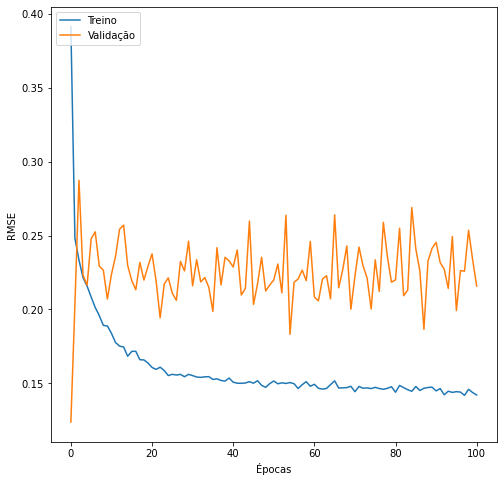

Média y original: 8.0223
Desvio padrão y original: 2.0204
Média y padronizado: 0.1378
Desvio padrão y padronizado: 0.2618


In [237]:
# Variáveis explicativas
x_train = df_train[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_train = x_train.to_numpy()

x_test = df_test[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_test = x_test.to_numpy()

# Variável dependente
y_train = df_train['M3_6mo']
y_train = y_train.to_numpy()
y_train = y_train.reshape(-1, 1)

y_test = df_test['M3_6mo']
y_test = y_test.to_numpy()
y_test = y_test.reshape(-1, 1)

# Pré processamento
x_scaler = MinMaxScaler()
x_scaler.fit(x_train)
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Otimização Bayesiana
trials = Trials()
bo_search = fmin(fn = bo_rna, 
                 space = bo_space,
                 algo = tpe.suggest,
                 max_evals = 50,
                 trials = trials)

# Hiperparâmetros
from hyperopt import space_eval

bo_melhor_hp = space_eval(bo_space, bo_search)
print('Melhor conjunto de hiperparâmetros: ', bo_melhor_hp)

# Rede Neural
modelo_bo = modelo_DL(num_layers = bo_melhor_hp['num_layers'],
                      num_neurons = bo_melhor_hp['num_neurons'],
                      fn_activ = bo_melhor_hp['fn_activ'],
                      dropout = bo_melhor_hp['dropout'])

hist_bo = modelo_bo.fit(x_train_scaled, 
                        y_train_scaled,
                        epochs = n_epochs,
                        batch_size = n_batchs,
                        validation_split = 0.2,
                        callbacks = callback,
                        verbose = 0)

# RMSE padronizado
score_train, rmse_train = modelo_bo.evaluate(x_train_scaled, y_train_scaled, verbose=0)
score_test, rmse_test = modelo_bo.evaluate(x_test_scaled, y_test_scaled, verbose=0)

print('RMSE padronizado no conjunto de Treino: {:.4}'.format(rmse_train))
print('RMSE padronizado no conjunto de Teste: {:.4}'.format(rmse_test))

# RMSE original
y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('RMSE Treino: ', sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
print('RMSE Teste: ', sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

# Gráfico com a evolução do treinamento
fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(hist_bo.history['root_mean_squared_error'])
plt.plot(hist_bo.history['val_root_mean_squared_error'])
plt.ylabel('RMSE')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()
fig.savefig('MLP_3M_6mo.pdf', bbox_inches='tight')

# Média e Desvio padrão
y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('Média y original: %.4f'% y_test_pred.mean())
print('Desvio padrão y original: %.4f'% y_test_pred.std())

print('Média y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).mean())
print('Desvio padrão y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).std())

## 3M 12mo ahead

Hiperparametros testados:                             
{'dropout': 0.4, 'fn_activ': 'relu', 'num_layers': 2, 'num_neurons': 4}
RMSE Teste:                                           
6.394558544736394                                     
Hiperparametros testados:                                                      
{'dropout': 0.0, 'fn_activ': 'relu', 'num_layers': 8, 'num_neurons': 64}       
RMSE Teste:                                                                    
5.1062949887485365                                                             
Hiperparametros testados:                                                       
{'dropout': 0.1, 'fn_activ': 'tanh', 'num_layers': 5, 'num_neurons': 64}        
RMSE Teste:                                                                     
4.96697777933985                                                                
Hiperparametros testados:                                                       
{'dropout': 0.30000000000000004, 'fn_a

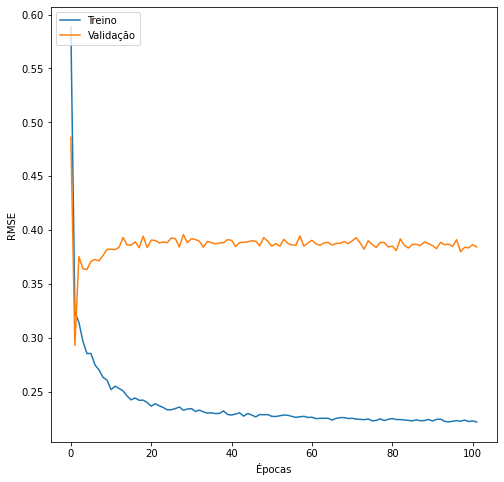

Média y original: 9.4330
Desvio padrão y original: 1.2250
Média y padronizado: 0.3206
Desvio padrão y padronizado: 0.1587


In [247]:
# Variáveis ------------------------------------------------------------------------------------------------------------------------------ #
    
# Variáveis explicativas
x_train = df_train[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_train = x_train.to_numpy()

x_test = df_test[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_test = x_test.to_numpy()

# Variável dependente
y_train = df_train['M3_12mo']
y_train = y_train.to_numpy()
y_train = y_train.reshape(-1, 1)

y_test = df_test['M3_12mo']
y_test = y_test.to_numpy()
y_test = y_test.reshape(-1, 1)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Pré processamento ---------------------------------------------------------------------------------------------------------------------- #

x_scaler = MinMaxScaler()
x_scaler.fit(x_train)
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Espaço Hiperparamétrico ---------------------------------------------------------------------------------------------------------------- #

# Número de camadas
ehp_layers = np.arange(1, 10, 1)

# Número de neurônios
ehp_neurons = np.power(2, np.arange(1, 8, 1)) 

# Função de ativação
ehp_fnactiv = ['relu','tanh']

# Dropout
ehp_dropout = np.arange(0, 0.5, 0.1)

# Definição do dicionário de parâmetros
param_grid = dict(num_layers = ehp_layers,
                  num_neurons = ehp_neurons,
                  fn_activ = ehp_fnactiv,
                  dropout = ehp_dropout
                 )

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Otimização Bayesiana ------------------------------------------------------------------------------------------------------------------- #

bo_space = {'num_layers': hp.choice('num_layers', param_grid['num_layers']),
            'num_neurons': hp.choice('num_neurons', param_grid['num_neurons']),
            'fn_activ': hp.choice('fn_activ', param_grid['fn_activ']),
            'dropout' : hp.choice('dropout', param_grid['dropout'])
           }

trials = Trials()
bo_search = fmin(fn = bo_rna, 
                 space = bo_space,
                 algo = tpe.suggest,
                 max_evals = 50,
                 trials = trials)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Hiperparâmetros ------------------------------------------------------------------------------------------------------------------------ #

bo_melhor_hp = space_eval(bo_space, bo_search)
print('Melhor conjunto de hiperparâmetros: ', bo_melhor_hp)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Rede Neural ---------------------------------------------------------------------------------------------------------------------------- #

modelo_bo = modelo_DL(num_layers = bo_melhor_hp['num_layers'],
                      num_neurons = bo_melhor_hp['num_neurons'],
                      fn_activ = bo_melhor_hp['fn_activ'],
                      dropout = bo_melhor_hp['dropout']
                     )

hist_bo = modelo_bo.fit(x_train_scaled, 
                        y_train_scaled,
                        epochs = n_epochs,
                        batch_size = n_batchs,
                        validation_split = 0.2,
                        callbacks = callback,
                        verbose = 0)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE padronizado ----------------------------------------------------------------------------------------------------------------------- #

score_train, rmse_train = modelo_bo.evaluate(x_train_scaled, y_train_scaled, verbose=0)
score_test, rmse_test = modelo_bo.evaluate(x_test_scaled, y_test_scaled, verbose=0)

print('RMSE padronizado no conjunto de Treino: {:.4}'.format(rmse_train))
print('RMSE padronizado no conjunto de Teste: {:.4}'.format(rmse_test))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE original -------------------------------------------------------------------------------------------------------------------------- #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('RMSE Treino: ', sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
print('RMSE Teste: ', sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Gráfico com a evolução do treinamento -------------------------------------------------------------------------------------------------- #

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(hist_bo.history['root_mean_squared_error'])
plt.plot(hist_bo.history['val_root_mean_squared_error'])
plt.ylabel('RMSE')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()
fig.savefig('MLP_3M_12mo.pdf', bbox_inches='tight')

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Média e Desvio padrão ------------------------------------------------------------------------------------------------------------------ #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('Média y original: %.4f'% y_test_pred.mean())
print('Desvio padrão y original: %.4f'% y_test_pred.std())

print('Média y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).mean())
print('Desvio padrão y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).std())

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Previsão M12

## M12 1mo ahead

Hiperparametros testados:                             
{'dropout': 0.30000000000000004, 'fn_activ': 'tanh', 'num_layers': 6, 'num_neurons': 128}
RMSE Teste:                                           
0.5249823715495113                                    
Hiperparametros testados:                                                       
{'dropout': 0.4, 'fn_activ': 'tanh', 'num_layers': 3, 'num_neurons': 32}        
RMSE Teste:                                                                     
0.6088849665969401                                                              
Hiperparametros testados:                                                       
{'dropout': 0.1, 'fn_activ': 'relu', 'num_layers': 3, 'num_neurons': 32}        
RMSE Teste:                                                                     
1.242753669749907                                                               
Hiperparametros testados:                                                       
{'dropout': 0.1,

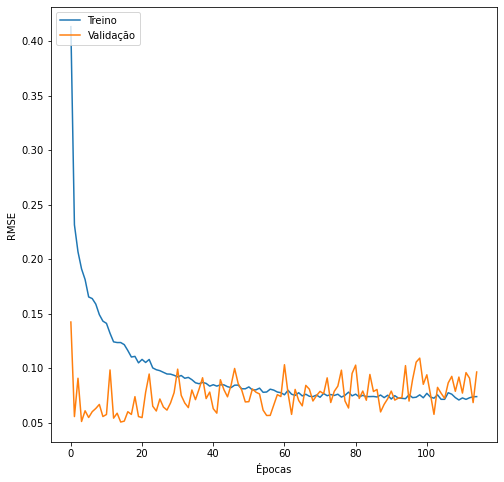

Média y original: 8.2296
Desvio padrão y original: 2.0842
Média y padronizado: 0.1506
Desvio padrão y padronizado: 0.2306


In [252]:
# Variáveis ------------------------------------------------------------------------------------------------------------------------------ #
    
# Variáveis explicativas
x_train = df_train[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_train = x_train.to_numpy()

x_test = df_test[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_test = x_test.to_numpy()

# Variável dependente
y_train = df_train['M12_1mo']
y_train = y_train.to_numpy()
y_train = y_train.reshape(-1, 1)

y_test = df_test['M12_1mo']
y_test = y_test.to_numpy()
y_test = y_test.reshape(-1, 1)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Pré processamento ---------------------------------------------------------------------------------------------------------------------- #

x_scaler = MinMaxScaler()
x_scaler.fit(x_train)
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Espaço Hiperparamétrico ---------------------------------------------------------------------------------------------------------------- #

# Número de camadas
ehp_layers = np.arange(1, 10, 1)

# Número de neurônios
ehp_neurons = np.power(2, np.arange(1, 8, 1)) 

# Função de ativação
ehp_fnactiv = ['relu','tanh']

# Dropout
ehp_dropout = np.arange(0, 0.5, 0.1)

# Definição do dicionário de parâmetros
param_grid = dict(num_layers = ehp_layers,
                  num_neurons = ehp_neurons,
                  fn_activ = ehp_fnactiv,
                  dropout = ehp_dropout
                 )

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Otimização Bayesiana ------------------------------------------------------------------------------------------------------------------- #

bo_space = {'num_layers': hp.choice('num_layers', param_grid['num_layers']),
            'num_neurons': hp.choice('num_neurons', param_grid['num_neurons']),
            'fn_activ': hp.choice('fn_activ', param_grid['fn_activ']),
            'dropout' : hp.choice('dropout', param_grid['dropout'])
           }

trials = Trials()
bo_search = fmin(fn = bo_rna, 
                 space = bo_space,
                 algo = tpe.suggest,
                 max_evals = 50,
                 trials = trials)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Hiperparâmetros ------------------------------------------------------------------------------------------------------------------------ #

bo_melhor_hp = space_eval(bo_space, bo_search)
print('Melhor conjunto de hiperparâmetros: ', bo_melhor_hp)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Rede Neural ---------------------------------------------------------------------------------------------------------------------------- #

modelo_bo = modelo_DL(num_layers = bo_melhor_hp['num_layers'],
                      num_neurons = bo_melhor_hp['num_neurons'],
                      fn_activ = bo_melhor_hp['fn_activ'],
                      dropout = bo_melhor_hp['dropout']
                     )

hist_bo = modelo_bo.fit(x_train_scaled, 
                        y_train_scaled,
                        epochs = n_epochs,
                        batch_size = n_batchs,
                        validation_split = 0.2,
                        callbacks = callback,
                        verbose = 0)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE padronizado ----------------------------------------------------------------------------------------------------------------------- #

score_train, rmse_train = modelo_bo.evaluate(x_train_scaled, y_train_scaled, verbose=0)
score_test, rmse_test = modelo_bo.evaluate(x_test_scaled, y_test_scaled, verbose=0)

print('RMSE padronizado no conjunto de Treino: {:.4}'.format(rmse_train))
print('RMSE padronizado no conjunto de Teste: {:.4}'.format(rmse_test))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE original -------------------------------------------------------------------------------------------------------------------------- #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('RMSE Treino: ', sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
print('RMSE Teste: ', sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Gráfico com a evolução do treinamento -------------------------------------------------------------------------------------------------- #

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(hist_bo.history['root_mean_squared_error'])
plt.plot(hist_bo.history['val_root_mean_squared_error'])
plt.ylabel('RMSE')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()
fig.savefig('MLP_12M_1mo.pdf', bbox_inches='tight')

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Média e Desvio padrão ------------------------------------------------------------------------------------------------------------------ #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('Média y original: %.4f'% y_test_pred.mean())
print('Desvio padrão y original: %.4f'% y_test_pred.std())

print('Média y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).mean())
print('Desvio padrão y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).std())

# ---------------------------------------------------------------------------------------------------------------------------------------- #

## M12 6mo ahead

Hiperparametros testados:                             
{'dropout': 0.1, 'fn_activ': 'relu', 'num_layers': 6, 'num_neurons': 2}
RMSE Teste:                                           
4.6978976358095865                                    
Hiperparametros testados:                                                       
{'dropout': 0.1, 'fn_activ': 'relu', 'num_layers': 5, 'num_neurons': 2}         
RMSE Teste:                                                                     
4.689996566572908                                                               
Hiperparametros testados:                                                       
{'dropout': 0.1, 'fn_activ': 'relu', 'num_layers': 9, 'num_neurons': 64}       
RMSE Teste:                                                                    
3.121997343887191                                                              
Hiperparametros testados:                                                      
{'dropout': 0.4, 'fn_activ': 'tanh', '

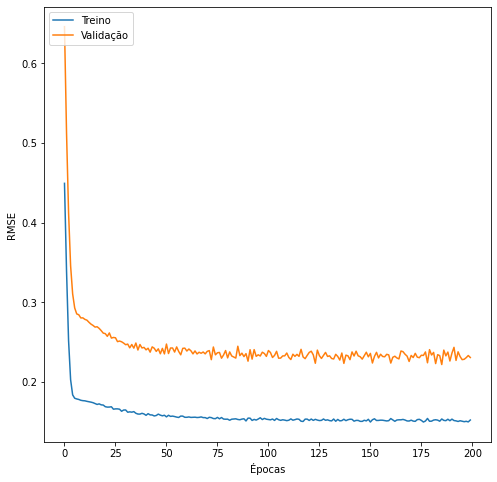

Média y original: 8.1419
Desvio padrão y original: 1.7076
Média y padronizado: 0.1409
Desvio padrão y padronizado: 0.1889


In [253]:
# Variáveis ------------------------------------------------------------------------------------------------------------------------------ #
    
# Variáveis explicativas
x_train = df_train[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_train = x_train.to_numpy()

x_test = df_test[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_test = x_test.to_numpy()

# Variável dependente
y_train = df_train['M12_6mo']
y_train = y_train.to_numpy()
y_train = y_train.reshape(-1, 1)

y_test = df_test['M12_6mo']
y_test = y_test.to_numpy()
y_test = y_test.reshape(-1, 1)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Pré processamento ---------------------------------------------------------------------------------------------------------------------- #

x_scaler = MinMaxScaler()
x_scaler.fit(x_train)
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Espaço Hiperparamétrico ---------------------------------------------------------------------------------------------------------------- #

# Número de camadas
ehp_layers = np.arange(1, 10, 1)

# Número de neurônios
ehp_neurons = np.power(2, np.arange(1, 8, 1)) 

# Função de ativação
ehp_fnactiv = ['relu','tanh']

# Dropout
ehp_dropout = np.arange(0, 0.5, 0.1)

# Definição do dicionário de parâmetros
param_grid = dict(num_layers = ehp_layers,
                  num_neurons = ehp_neurons,
                  fn_activ = ehp_fnactiv,
                  dropout = ehp_dropout
                 )

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Otimização Bayesiana ------------------------------------------------------------------------------------------------------------------- #

bo_space = {'num_layers': hp.choice('num_layers', param_grid['num_layers']),
            'num_neurons': hp.choice('num_neurons', param_grid['num_neurons']),
            'fn_activ': hp.choice('fn_activ', param_grid['fn_activ']),
            'dropout' : hp.choice('dropout', param_grid['dropout'])
           }

trials = Trials()
bo_search = fmin(fn = bo_rna, 
                 space = bo_space,
                 algo = tpe.suggest,
                 max_evals = 50,
                 trials = trials)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Hiperparâmetros ------------------------------------------------------------------------------------------------------------------------ #

bo_melhor_hp = space_eval(bo_space, bo_search)
print('Melhor conjunto de hiperparâmetros: ', bo_melhor_hp)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Rede Neural ---------------------------------------------------------------------------------------------------------------------------- #

modelo_bo = modelo_DL(num_layers = bo_melhor_hp['num_layers'],
                      num_neurons = bo_melhor_hp['num_neurons'],
                      fn_activ = bo_melhor_hp['fn_activ'],
                      dropout = bo_melhor_hp['dropout']
                     )

hist_bo = modelo_bo.fit(x_train_scaled, 
                        y_train_scaled,
                        epochs = n_epochs,
                        batch_size = n_batchs,
                        validation_split = 0.2,
                        callbacks = callback,
                        verbose = 0)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE padronizado ----------------------------------------------------------------------------------------------------------------------- #

score_train, rmse_train = modelo_bo.evaluate(x_train_scaled, y_train_scaled, verbose=0)
score_test, rmse_test = modelo_bo.evaluate(x_test_scaled, y_test_scaled, verbose=0)

print('RMSE padronizado no conjunto de Treino: {:.4}'.format(rmse_train))
print('RMSE padronizado no conjunto de Teste: {:.4}'.format(rmse_test))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE original -------------------------------------------------------------------------------------------------------------------------- #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('RMSE Treino: ', sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
print('RMSE Teste: ', sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Gráfico com a evolução do treinamento -------------------------------------------------------------------------------------------------- #

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(hist_bo.history['root_mean_squared_error'])
plt.plot(hist_bo.history['val_root_mean_squared_error'])
plt.ylabel('RMSE')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()
fig.savefig('MLP_12M_6mo.pdf', bbox_inches='tight')

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Média e Desvio padrão ------------------------------------------------------------------------------------------------------------------ #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('Média y original: %.4f'% y_test_pred.mean())
print('Desvio padrão y original: %.4f'% y_test_pred.std())

print('Média y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).mean())
print('Desvio padrão y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).std())

# ---------------------------------------------------------------------------------------------------------------------------------------- #

## M12 12mo ahead

Hiperparametros testados:                             
{'dropout': 0.2, 'fn_activ': 'tanh', 'num_layers': 5, 'num_neurons': 128}
RMSE Teste:                                           
5.646688805889741                                     
Hiperparametros testados:                                                      
{'dropout': 0.1, 'fn_activ': 'relu', 'num_layers': 2, 'num_neurons': 64}       
RMSE Teste:                                                                    
6.876399818000179                                                              
Hiperparametros testados:                                                      
{'dropout': 0.4, 'fn_activ': 'tanh', 'num_layers': 5, 'num_neurons': 32}       
RMSE Teste:                                                                    
5.692982800111512                                                              
Hiperparametros testados:                                                      
{'dropout': 0.2, 'fn_activ': 'relu', 'num

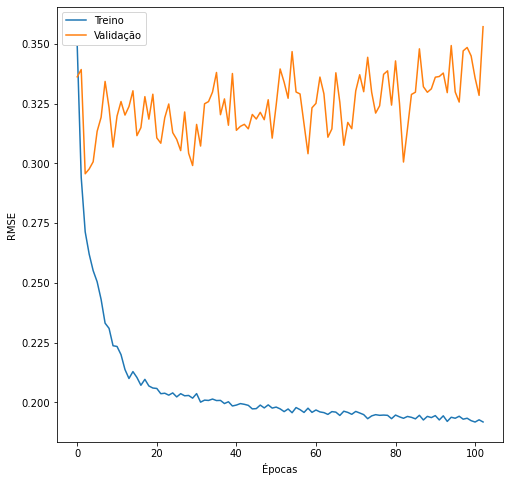

Média y original: 9.8631
Desvio padrão y original: 1.3491
Média y padronizado: 0.3312
Desvio padrão y padronizado: 0.1492


In [254]:
# Variáveis ------------------------------------------------------------------------------------------------------------------------------ #
    
# Variáveis explicativas
x_train = df_train[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_train = x_train.to_numpy()

x_test = df_test[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_test = x_test.to_numpy()

# Variável dependente
y_train = df_train['M12_12mo']
y_train = y_train.to_numpy()
y_train = y_train.reshape(-1, 1)

y_test = df_test['M12_12mo']
y_test = y_test.to_numpy()
y_test = y_test.reshape(-1, 1)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Pré processamento ---------------------------------------------------------------------------------------------------------------------- #

x_scaler = MinMaxScaler()
x_scaler.fit(x_train)
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Espaço Hiperparamétrico ---------------------------------------------------------------------------------------------------------------- #

# Número de camadas
ehp_layers = np.arange(1, 10, 1)

# Número de neurônios
ehp_neurons = np.power(2, np.arange(1, 8, 1)) 

# Função de ativação
ehp_fnactiv = ['relu','tanh']

# Dropout
ehp_dropout = np.arange(0, 0.5, 0.1)

# Definição do dicionário de parâmetros
param_grid = dict(num_layers = ehp_layers,
                  num_neurons = ehp_neurons,
                  fn_activ = ehp_fnactiv,
                  dropout = ehp_dropout
                 )

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Otimização Bayesiana ------------------------------------------------------------------------------------------------------------------- #

bo_space = {'num_layers': hp.choice('num_layers', param_grid['num_layers']),
            'num_neurons': hp.choice('num_neurons', param_grid['num_neurons']),
            'fn_activ': hp.choice('fn_activ', param_grid['fn_activ']),
            'dropout' : hp.choice('dropout', param_grid['dropout'])
           }

trials = Trials()
bo_search = fmin(fn = bo_rna, 
                 space = bo_space,
                 algo = tpe.suggest,
                 max_evals = 50,
                 trials = trials)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Hiperparâmetros ------------------------------------------------------------------------------------------------------------------------ #

bo_melhor_hp = space_eval(bo_space, bo_search)
print('Melhor conjunto de hiperparâmetros: ', bo_melhor_hp)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Rede Neural ---------------------------------------------------------------------------------------------------------------------------- #

modelo_bo = modelo_DL(num_layers = bo_melhor_hp['num_layers'],
                      num_neurons = bo_melhor_hp['num_neurons'],
                      fn_activ = bo_melhor_hp['fn_activ'],
                      dropout = bo_melhor_hp['dropout']
                     )

hist_bo = modelo_bo.fit(x_train_scaled, 
                        y_train_scaled,
                        epochs = n_epochs,
                        batch_size = n_batchs,
                        validation_split = 0.2,
                        callbacks = callback,
                        verbose = 0)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE padronizado ----------------------------------------------------------------------------------------------------------------------- #

score_train, rmse_train = modelo_bo.evaluate(x_train_scaled, y_train_scaled, verbose=0)
score_test, rmse_test = modelo_bo.evaluate(x_test_scaled, y_test_scaled, verbose=0)

print('RMSE padronizado no conjunto de Treino: {:.4}'.format(rmse_train))
print('RMSE padronizado no conjunto de Teste: {:.4}'.format(rmse_test))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE original -------------------------------------------------------------------------------------------------------------------------- #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('RMSE Treino: ', sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
print('RMSE Teste: ', sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Gráfico com a evolução do treinamento -------------------------------------------------------------------------------------------------- #

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(hist_bo.history['root_mean_squared_error'])
plt.plot(hist_bo.history['val_root_mean_squared_error'])
plt.ylabel('RMSE')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()
fig.savefig('MLP_12M_12mo.pdf', bbox_inches='tight')

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Média e Desvio padrão ------------------------------------------------------------------------------------------------------------------ #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('Média y original: %.4f'% y_test_pred.mean())
print('Desvio padrão y original: %.4f'% y_test_pred.std())

print('Média y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).mean())
print('Desvio padrão y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).std())

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Previsão M36

## M36 1mo ahead

Hiperparametros testados:                             
{'dropout': 0.1, 'fn_activ': 'tanh', 'num_layers': 1, 'num_neurons': 4}
RMSE Teste:                                           
0.8126775630971997                                    
Hiperparametros testados:                                                       
{'dropout': 0.4, 'fn_activ': 'relu', 'num_layers': 4, 'num_neurons': 32}        
RMSE Teste:                                                                     
2.125471981889973                                                               
Hiperparametros testados:                                                       
{'dropout': 0.2, 'fn_activ': 'relu', 'num_layers': 9, 'num_neurons': 128}       
RMSE Teste:                                                                     
1.7390526391147139                                                              
Hiperparametros testados:                                                       
{'dropout': 0.2, 'fn_activ': 'tanh

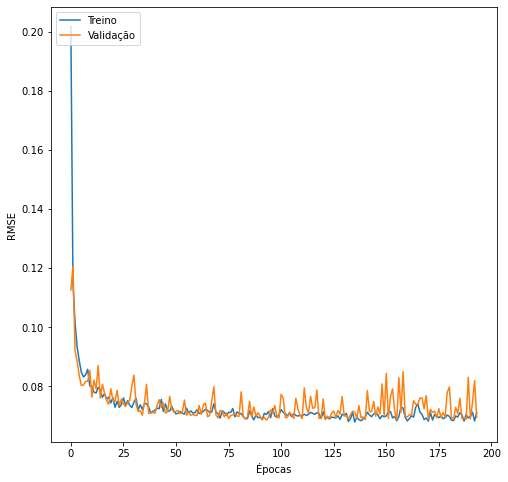

Média y original: 8.7992
Desvio padrão y original: 1.9802
Média y padronizado: 0.1405
Desvio padrão y padronizado: 0.1959


In [255]:
# Variáveis ------------------------------------------------------------------------------------------------------------------------------ #
    
# Variáveis explicativas
x_train = df_train[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_train = x_train.to_numpy()

x_test = df_test[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_test = x_test.to_numpy()

# Variável dependente
y_train = df_train['M36_1mo']
y_train = y_train.to_numpy()
y_train = y_train.reshape(-1, 1)

y_test = df_test['M36_1mo']
y_test = y_test.to_numpy()
y_test = y_test.reshape(-1, 1)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Pré processamento ---------------------------------------------------------------------------------------------------------------------- #

x_scaler = MinMaxScaler()
x_scaler.fit(x_train)
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Espaço Hiperparamétrico ---------------------------------------------------------------------------------------------------------------- #

# Número de camadas
ehp_layers = np.arange(1, 10, 1)

# Número de neurônios
ehp_neurons = np.power(2, np.arange(1, 8, 1)) 

# Função de ativação
ehp_fnactiv = ['relu','tanh']

# Dropout
ehp_dropout = np.arange(0, 0.5, 0.1)

# Definição do dicionário de parâmetros
param_grid = dict(num_layers = ehp_layers,
                  num_neurons = ehp_neurons,
                  fn_activ = ehp_fnactiv,
                  dropout = ehp_dropout
                 )

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Otimização Bayesiana ------------------------------------------------------------------------------------------------------------------- #

bo_space = {'num_layers': hp.choice('num_layers', param_grid['num_layers']),
            'num_neurons': hp.choice('num_neurons', param_grid['num_neurons']),
            'fn_activ': hp.choice('fn_activ', param_grid['fn_activ']),
            'dropout' : hp.choice('dropout', param_grid['dropout'])
           }

trials = Trials()
bo_search = fmin(fn = bo_rna, 
                 space = bo_space,
                 algo = tpe.suggest,
                 max_evals = 50,
                 trials = trials)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Hiperparâmetros ------------------------------------------------------------------------------------------------------------------------ #

bo_melhor_hp = space_eval(bo_space, bo_search)
print('Melhor conjunto de hiperparâmetros: ', bo_melhor_hp)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Rede Neural ---------------------------------------------------------------------------------------------------------------------------- #

modelo_bo = modelo_DL(num_layers = bo_melhor_hp['num_layers'],
                      num_neurons = bo_melhor_hp['num_neurons'],
                      fn_activ = bo_melhor_hp['fn_activ'],
                      dropout = bo_melhor_hp['dropout']
                     )

hist_bo = modelo_bo.fit(x_train_scaled, 
                        y_train_scaled,
                        epochs = n_epochs,
                        batch_size = n_batchs,
                        validation_split = 0.2,
                        callbacks = callback,
                        verbose = 0)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE padronizado ----------------------------------------------------------------------------------------------------------------------- #

score_train, rmse_train = modelo_bo.evaluate(x_train_scaled, y_train_scaled, verbose=0)
score_test, rmse_test = modelo_bo.evaluate(x_test_scaled, y_test_scaled, verbose=0)

print('RMSE padronizado no conjunto de Treino: {:.4}'.format(rmse_train))
print('RMSE padronizado no conjunto de Teste: {:.4}'.format(rmse_test))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE original -------------------------------------------------------------------------------------------------------------------------- #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('RMSE Treino: ', sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
print('RMSE Teste: ', sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Gráfico com a evolução do treinamento -------------------------------------------------------------------------------------------------- #

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(hist_bo.history['root_mean_squared_error'])
plt.plot(hist_bo.history['val_root_mean_squared_error'])
plt.ylabel('RMSE')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()
fig.savefig('MLP_36M_1mo.pdf', bbox_inches='tight')

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Média e Desvio padrão ------------------------------------------------------------------------------------------------------------------ #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('Média y original: %.4f'% y_test_pred.mean())
print('Desvio padrão y original: %.4f'% y_test_pred.std())

print('Média y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).mean())
print('Desvio padrão y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).std())

# ---------------------------------------------------------------------------------------------------------------------------------------- #

## 36M 6mo ahead

Hiperparametros testados:                             
{'dropout': 0.2, 'fn_activ': 'tanh', 'num_layers': 9, 'num_neurons': 8}
RMSE Teste:                                           
3.0306245568010373                                    
Hiperparametros testados:                                                       
{'dropout': 0.0, 'fn_activ': 'tanh', 'num_layers': 7, 'num_neurons': 4}         
RMSE Teste:                                                                     
2.0896831608940483                                                              
Hiperparametros testados:                                                       
{'dropout': 0.1, 'fn_activ': 'relu', 'num_layers': 6, 'num_neurons': 64}        
RMSE Teste:                                                                     
3.2160418016887835                                                              
Hiperparametros testados:                                                       
{'dropout': 0.4, 'fn_activ': 'relu

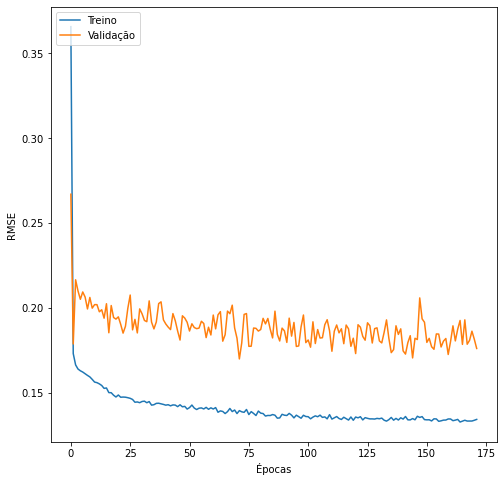

Média y original: 10.1702
Desvio padrão y original: 1.7593
Média y padronizado: 0.2761
Desvio padrão y padronizado: 0.1741


In [256]:
# Variáveis ------------------------------------------------------------------------------------------------------------------------------ #
    
# Variáveis explicativas
x_train = df_train[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_train = x_train.to_numpy()

x_test = df_test[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_test = x_test.to_numpy()

# Variável dependente
y_train = df_train['M36_6mo']
y_train = y_train.to_numpy()
y_train = y_train.reshape(-1, 1)

y_test = df_test['M36_6mo']
y_test = y_test.to_numpy()
y_test = y_test.reshape(-1, 1)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Pré processamento ---------------------------------------------------------------------------------------------------------------------- #

x_scaler = MinMaxScaler()
x_scaler.fit(x_train)
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Espaço Hiperparamétrico ---------------------------------------------------------------------------------------------------------------- #

# Número de camadas
ehp_layers = np.arange(1, 10, 1)

# Número de neurônios
ehp_neurons = np.power(2, np.arange(1, 8, 1)) 

# Função de ativação
ehp_fnactiv = ['relu','tanh']

# Dropout
ehp_dropout = np.arange(0, 0.5, 0.1)

# Definição do dicionário de parâmetros
param_grid = dict(num_layers = ehp_layers,
                  num_neurons = ehp_neurons,
                  fn_activ = ehp_fnactiv,
                  dropout = ehp_dropout
                 )

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Otimização Bayesiana ------------------------------------------------------------------------------------------------------------------- #

bo_space = {'num_layers': hp.choice('num_layers', param_grid['num_layers']),
            'num_neurons': hp.choice('num_neurons', param_grid['num_neurons']),
            'fn_activ': hp.choice('fn_activ', param_grid['fn_activ']),
            'dropout' : hp.choice('dropout', param_grid['dropout'])
           }

trials = Trials()
bo_search = fmin(fn = bo_rna, 
                 space = bo_space,
                 algo = tpe.suggest,
                 max_evals = 50,
                 trials = trials)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Hiperparâmetros ------------------------------------------------------------------------------------------------------------------------ #

bo_melhor_hp = space_eval(bo_space, bo_search)
print('Melhor conjunto de hiperparâmetros: ', bo_melhor_hp)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Rede Neural ---------------------------------------------------------------------------------------------------------------------------- #

modelo_bo = modelo_DL(num_layers = bo_melhor_hp['num_layers'],
                      num_neurons = bo_melhor_hp['num_neurons'],
                      fn_activ = bo_melhor_hp['fn_activ'],
                      dropout = bo_melhor_hp['dropout']
                     )

hist_bo = modelo_bo.fit(x_train_scaled, 
                        y_train_scaled,
                        epochs = n_epochs,
                        batch_size = n_batchs,
                        validation_split = 0.2,
                        callbacks = callback,
                        verbose = 0)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE padronizado ----------------------------------------------------------------------------------------------------------------------- #

score_train, rmse_train = modelo_bo.evaluate(x_train_scaled, y_train_scaled, verbose=0)
score_test, rmse_test = modelo_bo.evaluate(x_test_scaled, y_test_scaled, verbose=0)

print('RMSE padronizado no conjunto de Treino: {:.4}'.format(rmse_train))
print('RMSE padronizado no conjunto de Teste: {:.4}'.format(rmse_test))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE original -------------------------------------------------------------------------------------------------------------------------- #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('RMSE Treino: ', sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
print('RMSE Teste: ', sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Gráfico com a evolução do treinamento -------------------------------------------------------------------------------------------------- #

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(hist_bo.history['root_mean_squared_error'])
plt.plot(hist_bo.history['val_root_mean_squared_error'])
plt.ylabel('RMSE')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()
fig.savefig('MLP_36M_6mo.pdf', bbox_inches='tight')

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Média e Desvio padrão ------------------------------------------------------------------------------------------------------------------ #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('Média y original: %.4f'% y_test_pred.mean())
print('Desvio padrão y original: %.4f'% y_test_pred.std())

print('Média y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).mean())
print('Desvio padrão y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).std())

# ---------------------------------------------------------------------------------------------------------------------------------------- #

## 36M 12mo ahead

Hiperparametros testados:                             
{'dropout': 0.2, 'fn_activ': 'tanh', 'num_layers': 1, 'num_neurons': 64}
RMSE Teste:                                           
5.121702493129019                                     
Hiperparametros testados:                                                      
{'dropout': 0.4, 'fn_activ': 'relu', 'num_layers': 8, 'num_neurons': 8}        
RMSE Teste:                                                                    
5.2432789345460105                                                             
Hiperparametros testados:                                                      
{'dropout': 0.4, 'fn_activ': 'relu', 'num_layers': 5, 'num_neurons': 16}       
RMSE Teste:                                                                    
5.752309428104453                                                              
Hiperparametros testados:                                                      
{'dropout': 0.2, 'fn_activ': 'relu', 'num_

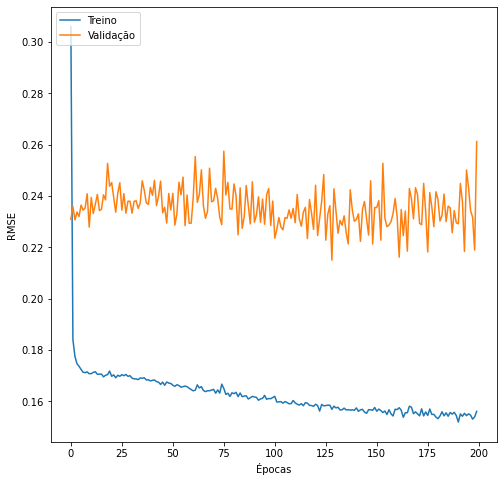

Média y original: 12.0440
Desvio padrão y original: 1.5864
Média y padronizado: 0.4615
Desvio padrão y padronizado: 0.1570


In [257]:
# Variáveis ------------------------------------------------------------------------------------------------------------------------------ #
    
# Variáveis explicativas
x_train = df_train[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_train = x_train.to_numpy()

x_test = df_test[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_test = x_test.to_numpy()

# Variável dependente
y_train = df_train['M36_12mo']
y_train = y_train.to_numpy()
y_train = y_train.reshape(-1, 1)

y_test = df_test['M36_12mo']
y_test = y_test.to_numpy()
y_test = y_test.reshape(-1, 1)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Pré processamento ---------------------------------------------------------------------------------------------------------------------- #

x_scaler = MinMaxScaler()
x_scaler.fit(x_train)
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Espaço Hiperparamétrico ---------------------------------------------------------------------------------------------------------------- #

# Número de camadas
ehp_layers = np.arange(1, 10, 1)

# Número de neurônios
ehp_neurons = np.power(2, np.arange(1, 8, 1)) 

# Função de ativação
ehp_fnactiv = ['relu','tanh']

# Dropout
ehp_dropout = np.arange(0, 0.5, 0.1)

# Definição do dicionário de parâmetros
param_grid = dict(num_layers = ehp_layers,
                  num_neurons = ehp_neurons,
                  fn_activ = ehp_fnactiv,
                  dropout = ehp_dropout
                 )

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Otimização Bayesiana ------------------------------------------------------------------------------------------------------------------- #

bo_space = {'num_layers': hp.choice('num_layers', param_grid['num_layers']),
            'num_neurons': hp.choice('num_neurons', param_grid['num_neurons']),
            'fn_activ': hp.choice('fn_activ', param_grid['fn_activ']),
            'dropout' : hp.choice('dropout', param_grid['dropout'])
           }

trials = Trials()
bo_search = fmin(fn = bo_rna, 
                 space = bo_space,
                 algo = tpe.suggest,
                 max_evals = 50,
                 trials = trials)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Hiperparâmetros ------------------------------------------------------------------------------------------------------------------------ #

bo_melhor_hp = space_eval(bo_space, bo_search)
print('Melhor conjunto de hiperparâmetros: ', bo_melhor_hp)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Rede Neural ---------------------------------------------------------------------------------------------------------------------------- #

modelo_bo = modelo_DL(num_layers = bo_melhor_hp['num_layers'],
                      num_neurons = bo_melhor_hp['num_neurons'],
                      fn_activ = bo_melhor_hp['fn_activ'],
                      dropout = bo_melhor_hp['dropout']
                     )

hist_bo = modelo_bo.fit(x_train_scaled, 
                        y_train_scaled,
                        epochs = n_epochs,
                        batch_size = n_batchs,
                        validation_split = 0.2,
                        callbacks = callback,
                        verbose = 0)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE padronizado ----------------------------------------------------------------------------------------------------------------------- #

score_train, rmse_train = modelo_bo.evaluate(x_train_scaled, y_train_scaled, verbose=0)
score_test, rmse_test = modelo_bo.evaluate(x_test_scaled, y_test_scaled, verbose=0)

print('RMSE padronizado no conjunto de Treino: {:.4}'.format(rmse_train))
print('RMSE padronizado no conjunto de Teste: {:.4}'.format(rmse_test))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE original -------------------------------------------------------------------------------------------------------------------------- #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('RMSE Treino: ', sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
print('RMSE Teste: ', sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Gráfico com a evolução do treinamento -------------------------------------------------------------------------------------------------- #

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(hist_bo.history['root_mean_squared_error'])
plt.plot(hist_bo.history['val_root_mean_squared_error'])
plt.ylabel('RMSE')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()
fig.savefig('MLP_36M_12mo.pdf', bbox_inches='tight')

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Média e Desvio padrão ------------------------------------------------------------------------------------------------------------------ #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('Média y original: %.4f'% y_test_pred.mean())
print('Desvio padrão y original: %.4f'% y_test_pred.std())

print('Média y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).mean())
print('Desvio padrão y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).std())

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Previsão M60

## M60 1mo ahead

Hiperparametros testados:                             
{'dropout': 0.1, 'fn_activ': 'tanh', 'num_layers': 7, 'num_neurons': 16}
RMSE Teste:                                           
0.9554182377529058                                    
Hiperparametros testados:                                                       
{'dropout': 0.30000000000000004, 'fn_activ': 'tanh', 'num_layers': 5, 'num_neurons': 64}
RMSE Teste:                                                                     
0.9838776804086178                                                              
Hiperparametros testados:                                                       
{'dropout': 0.0, 'fn_activ': 'tanh', 'num_layers': 1, 'num_neurons': 128}       
RMSE Teste:                                                                     
0.6322426538511112                                                              
Hiperparametros testados:                                                       
{'dropout': 0.1, 'fn_acti

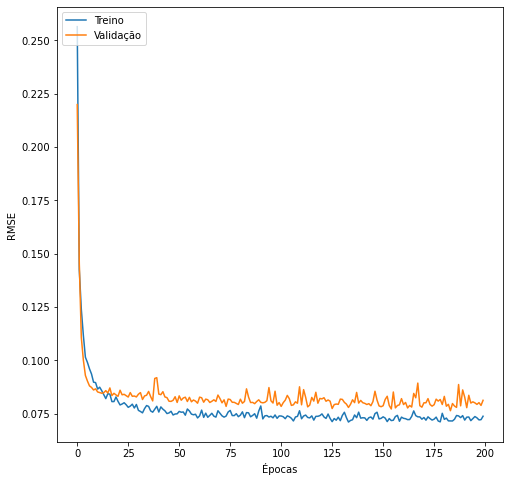

Média y original: 9.2103
Desvio padrão y original: 1.7798
Média y padronizado: 0.1124
Desvio padrão y padronizado: 0.1816


In [258]:
# Variáveis ------------------------------------------------------------------------------------------------------------------------------ #
    
# Variáveis explicativas
x_train = df_train[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_train = x_train.to_numpy()

x_test = df_test[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_test = x_test.to_numpy()

# Variável dependente
y_train = df_train['M60_1mo']
y_train = y_train.to_numpy()
y_train = y_train.reshape(-1, 1)

y_test = df_test['M60_1mo']
y_test = y_test.to_numpy()
y_test = y_test.reshape(-1, 1)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Pré processamento ---------------------------------------------------------------------------------------------------------------------- #

x_scaler = MinMaxScaler()
x_scaler.fit(x_train)
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Espaço Hiperparamétrico ---------------------------------------------------------------------------------------------------------------- #

# Número de camadas
ehp_layers = np.arange(1, 10, 1)

# Número de neurônios
ehp_neurons = np.power(2, np.arange(1, 8, 1)) 

# Função de ativação
ehp_fnactiv = ['relu','tanh']

# Dropout
ehp_dropout = np.arange(0, 0.5, 0.1)

# Definição do dicionário de parâmetros
param_grid = dict(num_layers = ehp_layers,
                  num_neurons = ehp_neurons,
                  fn_activ = ehp_fnactiv,
                  dropout = ehp_dropout
                 )

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Otimização Bayesiana ------------------------------------------------------------------------------------------------------------------- #

bo_space = {'num_layers': hp.choice('num_layers', param_grid['num_layers']),
            'num_neurons': hp.choice('num_neurons', param_grid['num_neurons']),
            'fn_activ': hp.choice('fn_activ', param_grid['fn_activ']),
            'dropout' : hp.choice('dropout', param_grid['dropout'])
           }

trials = Trials()
bo_search = fmin(fn = bo_rna, 
                 space = bo_space,
                 algo = tpe.suggest,
                 max_evals = 50,
                 trials = trials)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Hiperparâmetros ------------------------------------------------------------------------------------------------------------------------ #

bo_melhor_hp = space_eval(bo_space, bo_search)
print('Melhor conjunto de hiperparâmetros: ', bo_melhor_hp)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Rede Neural ---------------------------------------------------------------------------------------------------------------------------- #

modelo_bo = modelo_DL(num_layers = bo_melhor_hp['num_layers'],
                      num_neurons = bo_melhor_hp['num_neurons'],
                      fn_activ = bo_melhor_hp['fn_activ'],
                      dropout = bo_melhor_hp['dropout']
                     )

hist_bo = modelo_bo.fit(x_train_scaled, 
                        y_train_scaled,
                        epochs = n_epochs,
                        batch_size = n_batchs,
                        validation_split = 0.2,
                        callbacks = callback,
                        verbose = 0)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE padronizado ----------------------------------------------------------------------------------------------------------------------- #

score_train, rmse_train = modelo_bo.evaluate(x_train_scaled, y_train_scaled, verbose=0)
score_test, rmse_test = modelo_bo.evaluate(x_test_scaled, y_test_scaled, verbose=0)

print('RMSE padronizado no conjunto de Treino: {:.4}'.format(rmse_train))
print('RMSE padronizado no conjunto de Teste: {:.4}'.format(rmse_test))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE original -------------------------------------------------------------------------------------------------------------------------- #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('RMSE Treino: ', sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
print('RMSE Teste: ', sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Gráfico com a evolução do treinamento -------------------------------------------------------------------------------------------------- #

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(hist_bo.history['root_mean_squared_error'])
plt.plot(hist_bo.history['val_root_mean_squared_error'])
plt.ylabel('RMSE')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()
fig.savefig('MLP_60M_1mo.pdf', bbox_inches='tight')

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Média e Desvio padrão ------------------------------------------------------------------------------------------------------------------ #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('Média y original: %.4f'% y_test_pred.mean())
print('Desvio padrão y original: %.4f'% y_test_pred.std())

print('Média y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).mean())
print('Desvio padrão y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).std())

# ---------------------------------------------------------------------------------------------------------------------------------------- #

Hiperparametros testados:                             
{'dropout': 0.0, 'fn_activ': 'relu', 'num_layers': 2, 'num_neurons': 8}
RMSE Teste:                                           
2.6522968858697547                                    
Hiperparametros testados:                                                       
{'dropout': 0.4, 'fn_activ': 'tanh', 'num_layers': 9, 'num_neurons': 32}        
RMSE Teste:                                                                     
3.107728627409437                                                               
Hiperparametros testados:                                                       
{'dropout': 0.1, 'fn_activ': 'relu', 'num_layers': 8, 'num_neurons': 2}         
RMSE Teste:                                                                     
3.8979450057711493                                                              
Hiperparametros testados:                                                       
{'dropout': 0.30000000000000004, '

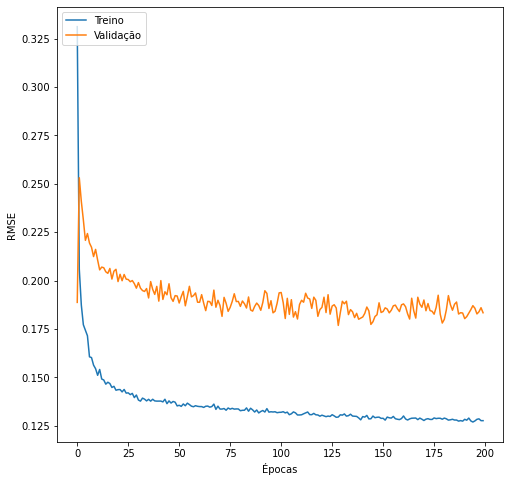

Média y original: 10.5262
Desvio padrão y original: 1.7260
Média y padronizado: 0.2466
Desvio padrão y padronizado: 0.1761


In [259]:
# Variáveis ------------------------------------------------------------------------------------------------------------------------------ #
    
# Variáveis explicativas
x_train = df_train[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_train = x_train.to_numpy()

x_test = df_test[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_test = x_test.to_numpy()

# Variável dependente
y_train = df_train['M60_6mo']
y_train = y_train.to_numpy()
y_train = y_train.reshape(-1, 1)

y_test = df_test['M60_6mo']
y_test = y_test.to_numpy()
y_test = y_test.reshape(-1, 1)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Pré processamento ---------------------------------------------------------------------------------------------------------------------- #

x_scaler = MinMaxScaler()
x_scaler.fit(x_train)
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Espaço Hiperparamétrico ---------------------------------------------------------------------------------------------------------------- #

# Número de camadas
ehp_layers = np.arange(1, 10, 1)

# Número de neurônios
ehp_neurons = np.power(2, np.arange(1, 8, 1)) 

# Função de ativação
ehp_fnactiv = ['relu','tanh']

# Dropout
ehp_dropout = np.arange(0, 0.5, 0.1)

# Definição do dicionário de parâmetros
param_grid = dict(num_layers = ehp_layers,
                  num_neurons = ehp_neurons,
                  fn_activ = ehp_fnactiv,
                  dropout = ehp_dropout
                 )

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Otimização Bayesiana ------------------------------------------------------------------------------------------------------------------- #

bo_space = {'num_layers': hp.choice('num_layers', param_grid['num_layers']),
            'num_neurons': hp.choice('num_neurons', param_grid['num_neurons']),
            'fn_activ': hp.choice('fn_activ', param_grid['fn_activ']),
            'dropout' : hp.choice('dropout', param_grid['dropout'])
           }

trials = Trials()
bo_search = fmin(fn = bo_rna, 
                 space = bo_space,
                 algo = tpe.suggest,
                 max_evals = 50,
                 trials = trials)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Hiperparâmetros ------------------------------------------------------------------------------------------------------------------------ #

bo_melhor_hp = space_eval(bo_space, bo_search)
print('Melhor conjunto de hiperparâmetros: ', bo_melhor_hp)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Rede Neural ---------------------------------------------------------------------------------------------------------------------------- #

modelo_bo = modelo_DL(num_layers = bo_melhor_hp['num_layers'],
                      num_neurons = bo_melhor_hp['num_neurons'],
                      fn_activ = bo_melhor_hp['fn_activ'],
                      dropout = bo_melhor_hp['dropout']
                     )

hist_bo = modelo_bo.fit(x_train_scaled, 
                        y_train_scaled,
                        epochs = n_epochs,
                        batch_size = n_batchs,
                        validation_split = 0.2,
                        callbacks = callback,
                        verbose = 0)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE padronizado ----------------------------------------------------------------------------------------------------------------------- #

score_train, rmse_train = modelo_bo.evaluate(x_train_scaled, y_train_scaled, verbose=0)
score_test, rmse_test = modelo_bo.evaluate(x_test_scaled, y_test_scaled, verbose=0)

print('RMSE padronizado no conjunto de Treino: {:.4}'.format(rmse_train))
print('RMSE padronizado no conjunto de Teste: {:.4}'.format(rmse_test))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE original -------------------------------------------------------------------------------------------------------------------------- #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('RMSE Treino: ', sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
print('RMSE Teste: ', sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Gráfico com a evolução do treinamento -------------------------------------------------------------------------------------------------- #

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(hist_bo.history['root_mean_squared_error'])
plt.plot(hist_bo.history['val_root_mean_squared_error'])
plt.ylabel('RMSE')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()
fig.savefig('MLP_60M_6mo.pdf', bbox_inches='tight')

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Média e Desvio padrão ------------------------------------------------------------------------------------------------------------------ #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('Média y original: %.4f'% y_test_pred.mean())
print('Desvio padrão y original: %.4f'% y_test_pred.std())

print('Média y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).mean())
print('Desvio padrão y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).std())

# ---------------------------------------------------------------------------------------------------------------------------------------- #

Hiperparametros testados:                             
{'dropout': 0.30000000000000004, 'fn_activ': 'tanh', 'num_layers': 4, 'num_neurons': 128}
RMSE Teste:                                           
4.430940332841708                                     
Hiperparametros testados:                                                      
{'dropout': 0.1, 'fn_activ': 'tanh', 'num_layers': 6, 'num_neurons': 2}        
RMSE Teste:                                                                    
4.5147102368298615                                                             
Hiperparametros testados:                                                      
{'dropout': 0.1, 'fn_activ': 'tanh', 'num_layers': 5, 'num_neurons': 32}       
RMSE Teste:                                                                    
4.538997982571074                                                              
Hiperparametros testados:                                                      
{'dropout': 0.4, 'fn_acti

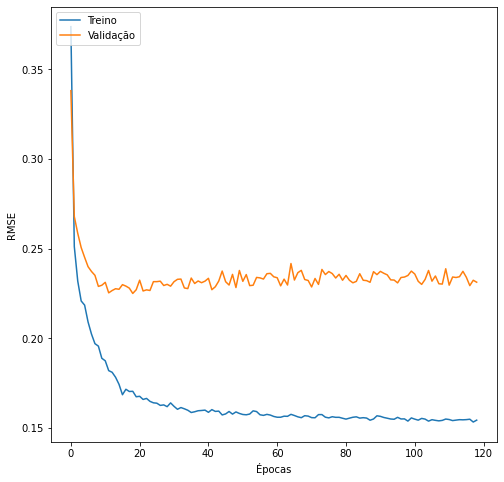

Média y original: 11.4099
Desvio padrão y original: 0.6161
Média y padronizado: 0.3368
Desvio padrão y padronizado: 0.0629


In [260]:
# Variáveis ------------------------------------------------------------------------------------------------------------------------------ #
    
# Variáveis explicativas
x_train = df_train[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_train = x_train.to_numpy()

x_test = df_test[['M1_t-1', 'M1_t-2', 'M1_t-3', 'M1_t-4', 'M1_t-5', 'M2_t-1', 'M2_t-2', 'M2_t-3', 'M2_t-4', 'M2_t-5', 'M3_t-1', 'M3_t-2', 'M3_t-3', 'M3_t-4', 'M3_t-5', 'M6_t-1', 'M6_t-2', 'M6_t-3', 'M6_t-4', 'M6_t-5', 'M9_t-1', 'M9_t-2', 'M9_t-3', 'M9_t-4', 'M9_t-5', 'M12_t-1', 'M12_t-2', 'M12_t-3', 'M12_t-4', 'M12_t-5', 'M24_t-1', 'M24_t-2', 'M24_t-3', 'M24_t-4', 'M24_t-5', 'M36_t-1', 'M36_t-2', 'M36_t-3', 'M36_t-4', 'M36_t-5', 'M48_t-1', 'M48_t-2', 'M48_t-3', 'M48_t-4', 'M48_t-5', 'M60_t-1', 'M60_t-2', 'M60_t-3', 'M60_t-4', 'M60_t-5']]
x_test = x_test.to_numpy()

# Variável dependente
y_train = df_train['M60_12mo']
y_train = y_train.to_numpy()
y_train = y_train.reshape(-1, 1)

y_test = df_test['M60_12mo']
y_test = y_test.to_numpy()
y_test = y_test.reshape(-1, 1)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Pré processamento ---------------------------------------------------------------------------------------------------------------------- #

x_scaler = MinMaxScaler()
x_scaler.fit(x_train)
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Espaço Hiperparamétrico ---------------------------------------------------------------------------------------------------------------- #

# Número de camadas
ehp_layers = np.arange(1, 10, 1)

# Número de neurônios
ehp_neurons = np.power(2, np.arange(1, 8, 1)) 

# Função de ativação
ehp_fnactiv = ['relu','tanh']

# Dropout
ehp_dropout = np.arange(0, 0.5, 0.1)

# Definição do dicionário de parâmetros
param_grid = dict(num_layers = ehp_layers,
                  num_neurons = ehp_neurons,
                  fn_activ = ehp_fnactiv,
                  dropout = ehp_dropout
                 )

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Otimização Bayesiana ------------------------------------------------------------------------------------------------------------------- #

bo_space = {'num_layers': hp.choice('num_layers', param_grid['num_layers']),
            'num_neurons': hp.choice('num_neurons', param_grid['num_neurons']),
            'fn_activ': hp.choice('fn_activ', param_grid['fn_activ']),
            'dropout' : hp.choice('dropout', param_grid['dropout'])
           }

trials = Trials()
bo_search = fmin(fn = bo_rna, 
                 space = bo_space,
                 algo = tpe.suggest,
                 max_evals = 50,
                 trials = trials)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Hiperparâmetros ------------------------------------------------------------------------------------------------------------------------ #

bo_melhor_hp = space_eval(bo_space, bo_search)
print('Melhor conjunto de hiperparâmetros: ', bo_melhor_hp)

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Rede Neural ---------------------------------------------------------------------------------------------------------------------------- #

modelo_bo = modelo_DL(num_layers = bo_melhor_hp['num_layers'],
                      num_neurons = bo_melhor_hp['num_neurons'],
                      fn_activ = bo_melhor_hp['fn_activ'],
                      dropout = bo_melhor_hp['dropout']
                     )

hist_bo = modelo_bo.fit(x_train_scaled, 
                        y_train_scaled,
                        epochs = n_epochs,
                        batch_size = n_batchs,
                        validation_split = 0.2,
                        callbacks = callback,
                        verbose = 0)
    
# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE padronizado ----------------------------------------------------------------------------------------------------------------------- #

score_train, rmse_train = modelo_bo.evaluate(x_train_scaled, y_train_scaled, verbose=0)
score_test, rmse_test = modelo_bo.evaluate(x_test_scaled, y_test_scaled, verbose=0)

print('RMSE padronizado no conjunto de Treino: {:.4}'.format(rmse_train))
print('RMSE padronizado no conjunto de Teste: {:.4}'.format(rmse_test))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# RMSE original -------------------------------------------------------------------------------------------------------------------------- #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('RMSE Treino: ', sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
print('RMSE Teste: ', sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

# ---------------------------------------------------------------------------------------------------------------------------------------- #
    
# Gráfico com a evolução do treinamento -------------------------------------------------------------------------------------------------- #

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(hist_bo.history['root_mean_squared_error'])
plt.plot(hist_bo.history['val_root_mean_squared_error'])
plt.ylabel('RMSE')
plt.xlabel('Épocas')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()
fig.savefig('MLP_60M_12mo.pdf', bbox_inches='tight')

# ---------------------------------------------------------------------------------------------------------------------------------------- #

# Média e Desvio padrão ------------------------------------------------------------------------------------------------------------------ #

y_train_pred = y_scaler.inverse_transform(modelo_bo.predict(x_train_scaled))
y_test_pred = y_scaler.inverse_transform(modelo_bo.predict(x_test_scaled))

print('Média y original: %.4f'% y_test_pred.mean())
print('Desvio padrão y original: %.4f'% y_test_pred.std())

print('Média y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).mean())
print('Desvio padrão y padronizado: %.4f'% modelo_bo.predict(x_test_scaled).std())

# ---------------------------------------------------------------------------------------------------------------------------------------- #